## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (15%)
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7260000109672546
epoch 2: valid acc = 0.7929999828338623
epoch 3: valid acc = 0.8299999833106995
epoch 4: valid acc = 0.8460000157356262
epoch 5: valid acc = 0.8544999957084656
epoch 6: valid acc = 0.859499990940094
epoch 7: valid acc = 0.8654999732971191
epoch 8: valid acc = 0.8654999732971191
epoch 9: valid acc = 0.8690000176429749
epoch 10: valid acc = 0.8694999814033508
epoch 11: valid acc = 0.8709999918937683
epoch 12: valid acc = 0.8725000023841858
epoch 13: valid acc = 0.8715000152587891
epoch 14: valid acc = 0.871999979019165
epoch 15: valid acc = 0.8734999895095825
test acc = 0.8639000058174133


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your 4-layer MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

In [4]:
# Create you MLP using TensorFlow functions.
hidden_dim = [300, 300, 300]
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim[0]).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim[0],)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim[0], hidden_dim[1]).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim[1],)).astype('float32'))
        self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dim[1], hidden_dim[2]).astype('float32'))
        self.b3 = tf.Variable(np.zeros((hidden_dim[2],)).astype('float32'))
        self.W4 = tf.Variable(1e-2*np.random.rand(hidden_dim[2], 20).astype('float32'))
        self.b4 = tf.Variable(np.zeros((20,)).astype('float32'))
        
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2  = tf.nn.relu(tf.matmul(h1,     self.W2) + self.b2)
        h3  = tf.nn.relu(tf.matmul(h2,     self.W3) + self.b3)
        out = tf.matmul(h3, self.W4) + self.b4
        return out

  # Define and calculate loss function (Note that in eager execution, loss must be in a function)
    def loss(model, inputs, targets, reg = tf.constant(0.01)):
        out = model(inputs)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
        L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2) + tf.nn.l2_loss(model.W3) + tf.nn.l2_loss(model.W4)
        return tf.reduce_mean(cross_entropy) + reg * L2_loss  

  # calculate gradients for all variables using tf.GradientTape
    def grad(model, inputs, targets, reg = tf.constant(0.01)):
        with tf.GradientTape() as tape:
            loss_value = loss(model, inputs, targets, reg=reg)
        return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2,  model.W3, model.b3,  model.W4, model.b4])  
  
    # calculate classification accuracy
    def eval_acc(model, inputs, targets):
        correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 100
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4]))
        
    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.07199999690055847
epoch 2: valid acc = 0.039500001817941666
epoch 3: valid acc = 0.03750000149011612
epoch 4: valid acc = 0.04100000113248825
epoch 5: valid acc = 0.12200000137090683
epoch 6: valid acc = 0.13850000500679016
epoch 7: valid acc = 0.14350000023841858
epoch 8: valid acc = 0.13699999451637268
epoch 9: valid acc = 0.13600000739097595
epoch 10: valid acc = 0.13500000536441803
epoch 11: valid acc = 0.13199999928474426
epoch 12: valid acc = 0.1289999932050705
epoch 13: valid acc = 0.12950000166893005
epoch 14: valid acc = 0.12950000166893005
epoch 15: valid acc = 0.12950000166893005
epoch 16: valid acc = 0.11699999868869781
epoch 17: valid acc = 0.14550000429153442
epoch 18: valid acc = 0.1459999978542328
epoch 19: valid acc = 0.14550000429153442
epoch 20: valid acc = 0.14399999380111694
epoch 21: valid acc = 0.14249999821186066
epoch 22: valid acc = 0.13899999856948853
epoch 23: valid acc = 0.13850000500679016
epoch 24: valid acc = 0.13650000095367432
ep

### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [5]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential

ds_train, ds_test = train, test
# END of your code
#############################################################



#############################################################
# TODO: compile the model, set optimizer and loss

def normalize_img(image, label):
    
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)
# END of your code
#############################################################

AttributeError: 'tuple' object has no attribute 'map'

## Part 2: t-SNE (5%)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [13]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [14]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [15]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=25.0)
print("it takes {} seconds".format(time.time()-tic))

2.8481277136794976
The 100 th loop cost: 11.959411700089818, computation time: 1.6807594299316406
The 200 th loop cost: 0.5801747771728983, computation time: 3.354994058609009
The 300 th loop cost: 0.5419354651661387, computation time: 5.039815902709961
The 400 th loop cost: 0.5350840598940342, computation time: 6.718538284301758
The 500 th loop cost: 0.5334556306708648, computation time: 8.406922817230225
The 600 th loop cost: 0.5327946464219647, computation time: 10.084709644317627
The 700 th loop cost: 0.5324582272682576, computation time: 11.765212297439575
The 800 th loop cost: 0.5322642771732994, computation time: 13.453281164169312
The 900 th loop cost: 0.5321439467739444, computation time: 15.12567400932312
The 1000 th loop cost: 0.5320635864122105, computation time: 16.82370615005493
it takes 17.50888967514038 seconds


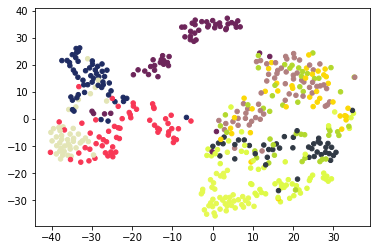

In [16]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [17]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.096, new learning rate = 0.00095
epoch 2: valid acc = 0.096, new learning rate = 0.0009025
epoch 3: valid acc = 0.096, new learning rate = 0.000857375
epoch 4: valid acc = 0.096, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.096, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.096, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.096, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.096, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.096, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.096, new learning rate = 0.0005987369392383785
test acc: 0.1


0.1

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [18]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then   #
# apply softmax to obtain output of the MLP model.                          #
#############################################################################
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X) 
X = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

NameError: name 'affine_forward' is not defined

/home/ecbm4040/A1/utils/features/tsne.py:16: RuntimeWarning: invalid value encountered in true_divide
  P = P / np.sum(P)


760.5384674854263
The 100 th loop cost: 11.690189808485178, computation time: 1.6815268993377686
The 200 th loop cost: 0.5356639778701312, computation time: 3.35495924949646
The 300 th loop cost: 0.5087765842729088, computation time: 5.053848743438721
The 400 th loop cost: 0.5048986236449425, computation time: 6.7995970249176025
The 500 th loop cost: 0.504172018465806, computation time: 8.52906346321106
The 600 th loop cost: 0.5039431013733014, computation time: 10.1916983127594
The 700 th loop cost: 0.50385382812439, computation time: 11.856149911880493
The 800 th loop cost: 0.5038148528188743, computation time: 13.532325267791748
The 900 th loop cost: 0.5037965115525473, computation time: 15.195399522781372
The 1000 th loop cost: 0.5037875866293162, computation time: 16.884082078933716


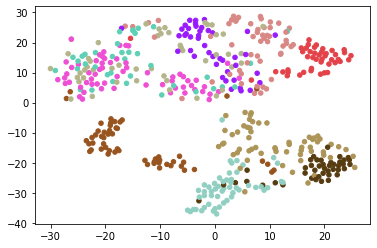

In [19]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data                             #
#############################################################################
Y = tsne(X, low_dim=2, perplexity=30.0)

labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [22]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]


#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X) 
X = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)

Y = tsne(X, low_dim=2, perplexity=25.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

NameError: name 'affine_forward' is not defined

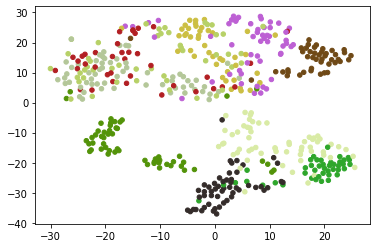

In [21]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################